In [18]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

load_dotenv(override=True)

# Setup MLflow Tracking
TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment("California_House_Price_Prediction")

<Experiment: artifact_location='s3://mlflow-bucket/5', creation_time=1770540647283, experiment_id='5', last_update_time=1770540647283, lifecycle_stage='active', name='California_House_Price_Prediction', tags={}>

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data is ready. Train shape: {X_train.shape}")
X.head(3) 

Data is ready. Train shape: (16512, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24


Start training experiments...
Run: {'n_estimators': 50, 'max_depth': 5} -> R2 Score: 0.6469
🏃 View run RandomForest_n50_d5 at: http://localhost:5000/#/experiments/5/runs/62d2c639ae0d444db7a88ef2a6174dd8
🧪 View experiment at: http://localhost:5000/#/experiments/5
Run: {'n_estimators': 100, 'max_depth': 10} -> R2 Score: 0.7737
🏃 View run RandomForest_n100_d10 at: http://localhost:5000/#/experiments/5/runs/0139995367ba4025936c01f4667d8f7d
🧪 View experiment at: http://localhost:5000/#/experiments/5
Run: {'n_estimators': 200, 'max_depth': 20} -> R2 Score: 0.8057
🏃 View run RandomForest_n200_d20 at: http://localhost:5000/#/experiments/5/runs/32f79dd0df2946858297fcb67314246c
🧪 View experiment at: http://localhost:5000/#/experiments/5
Experiment completed!


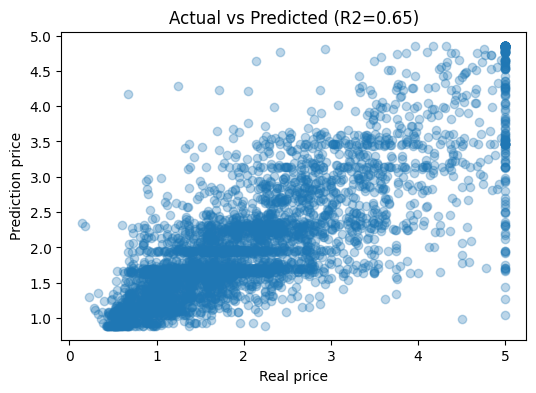

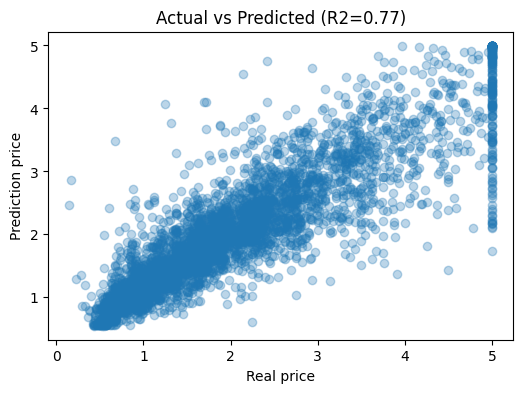

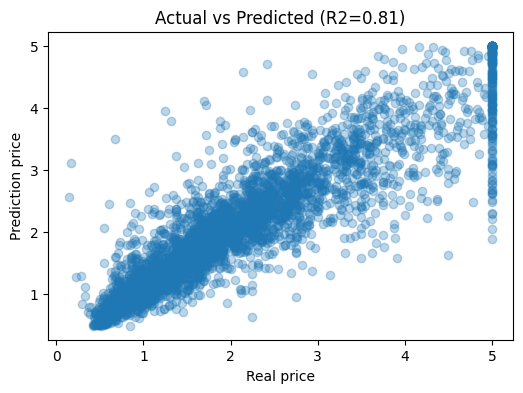

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

params_grid = [
    {"n_estimators": 50, "max_depth": 5},
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 200, "max_depth": 20}
]

print("Start training experiments...")

for params in params_grid:
    with mlflow.start_run(run_name=f"RandomForest_n{params['n_estimators']}_d{params['max_depth']}"):
        mlflow.log_params(params)
        
        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("r2_score", r2)
        
        plt.figure(figsize=(6,4))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.xlabel("Real price")
        plt.ylabel("Prediction price")
        plt.title(f"Actual vs Predicted (R2={r2:.2f})")
        
        img_path = "prediction_plot.png"
        plt.savefig(img_path)
        mlflow.log_artifact(img_path) 
        
        mlflow.sklearn.log_model(
            sk_model=model, 
            name="model",
            serialization_format="skops",
            pip_requirements=["scikit-learn==1.8.0", "skops==0.13.0", "pandas"]
        )
        
        print(f"Run: {params} -> R2 Score: {r2:.4f}")

print("Experiment completed!")

In [12]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("California_House_Price_Prediction")

# Search & Sort
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string="",
    order_by=["metrics.r2_score DESC"],
    max_results=1
)

best_run = runs[0]
best_r2 = best_run.data.metrics['r2_score']
best_run_id = best_run.info.run_id

print(f"🏆 Best Run ID: {best_run_id}")
print(f"🏆 R2 Score: {best_r2:.4f}")

model_name = "California_Housing_Model"
try:
    client.create_registered_model(model_name)
except:
    pass

result = client.create_model_version(
    name=model_name,
    source=f"runs:/{best_run_id}/model",
    run_id=best_run_id
)

client.set_model_version_tag(
    name=model_name,
    version=result.version,
    key="stage",
    value="production_ready"
)

print(f"✅ model registered '{model_name}' version {result.version}. Ready deploy!")

🏆 Best Run ID: 9a5039f0d906425cab91ba317cded75e
🏆 R2 Score: 0.8057


2026/02/08 16:11:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: California_Housing_Model, version 1


✅ model registered 'California_Housing_Model' version 1. Ready deploy!
